# Exploratory Research on Image Classification using Tensorflow and Perceptual Hashing Algorithm

## Source Code References
*    Title: TensorFlow-Tutorials
*    Original author is Magnus Erik Hvass Pedersen
*    Availability: https://github.com/Hvass-Labs/TensorFlow-Tutorials

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import prettytensor as pt
import mysql.connector
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import csv
import datetime
import time
import re
import statsmodels.api as sm
import mysql
from prettytable import PrettyTable
import itertools
from itertools import chain
from PIL import Image
import imagehash
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from PIL import Image

## Part1 Data Processing

### 1. Download dataset and store the label and image address information in a table of the data base created on Google Cloud Platform

In [144]:
label1= pd.read_csv("/Users/lisha/Desktop/BigData/Assignment3/trainLabels.csv", sep=',')

In [11]:
list_col=['ImageID','LabelName','Type','ImageAddr']

In [13]:
df=pd.DataFrame(columns=list_col)

In [14]:
df['ImageID']=label1['id']
df['LabelName']=label1['label']
df['Type']=label1['id']

In [15]:
df.loc[df['ImageID']<=40000, 'Type'] = 'train'
df.loc[df['ImageID']>40000, 'Type'] = 'test'

In [107]:
for i in range(len(df)):
    df.loc[i,'ImageAddr']='/Users/lisha/Desktop/train/'+ str(i+1) +'.png'

In [108]:
df.to_csv("/Users/lisha/Desktop/ImageLabel.txt", sep=',',index=False, )

In [5]:
# Open terminal to start proxy past this command: "./cloud_sql_proxy -instances=image-category-184805:us-east1:project7390=tcp:3306 &"
cnx = mysql.connector.connect(user='root', password='GoHusky!',
                              host='127.0.0.1',
                              database='ImageLabel')
c=cnx.cursor()

In [8]:
sql = """CREATE TABLE ImageLabel_local (ImageID int NOT NULL, LabelName  CHAR(20) NOT NULL, Type CHAR(10) NOT NULL, ImageAddr CHAR(255) NOT NULL)"""
c.execute(sql)

In [7]:
query = "LOAD DATA LOCAL INFILE '/Users/lisha/Desktop/ImageLabel.txt' INTO TABLE ImageLabel_local FIELDS TERMINATED BY ','  Lines Terminated BY '\n' (ImageID,LabelName,Type,ImageAddr)"
c.execute( query )
cnx.commit()

In [113]:
# A function to print returned data in a better form
def print_table(c):
    rows=c.fetchall()
    pt = PrettyTable([i[0] for i in c.description])
    pt.align= "l"
    for row in rows:
        pt.add_row(row)
    print (pt)

In [114]:
# Database I created
c.execute("""SELECT * FROM ImageLabel_local LIMIT 10""")
print_table(c)

+---------+------------+-------+-----------------------------------+
| ImageID | LabelName  | Type  | ImageAddr                         |
+---------+------------+-------+-----------------------------------+
| 1       | frog       | train | /Users/lisha/Desktop/train/1.png  |
| 2       | truck      | train | /Users/lisha/Desktop/train/2.png  |
| 3       | truck      | train | /Users/lisha/Desktop/train/3.png  |
| 4       | deer       | train | /Users/lisha/Desktop/train/4.png  |
| 5       | automobile | train | /Users/lisha/Desktop/train/5.png  |
| 6       | automobile | train | /Users/lisha/Desktop/train/6.png  |
| 7       | bird       | train | /Users/lisha/Desktop/train/7.png  |
| 8       | horse      | train | /Users/lisha/Desktop/train/8.png  |
| 9       | ship       | train | /Users/lisha/Desktop/train/9.png  |
| 10      | cat        | train | /Users/lisha/Desktop/train/10.png |
+---------+------------+-------+-----------------------------------+


### 2. Process data to suitable set for tensorflow

In [9]:
# This function is used to de-tuple list of tuples
def tuple_list(tuplelist):
    return list(itertools.chain(*tuplelist))

#### Get images and label lists with label name cat/dog/truck and cat&dog

In [10]:
c=cnx.cursor()
c.execute("""SELECT LabelName FROM ImageLabel_local WHERE LabelName='cat'""")
list_label_cat=tuple_list(c.fetchall())
c.execute("""SELECT LabelName FROM ImageLabel_local WHERE LabelName='dog'""")
list_label_dog=tuple_list(c.fetchall())
c.execute("""SELECT LabelName FROM ImageLabel_local WHERE LabelName='truck'""")
list_label_truck=tuple_list(c.fetchall())
c.execute("""SELECT LabelName FROM ImageLabel_local""")
list_label=tuple_list(c.fetchall())

In [11]:
c=cnx.cursor()
c.execute("""SELECT ImageAddr FROM ImageLabel_local WHERE LabelName='cat'""")
list_file_cat=tuple_list(c.fetchall())
c.execute("""SELECT ImageAddr FROM ImageLabel_local WHERE LabelName='dog'""")
list_file_dog=tuple_list(c.fetchall())
c.execute("""SELECT ImageAddr FROM ImageLabel_local WHERE LabelName='truck'""")
list_file_truck=tuple_list(c.fetchall())
c.execute("""SELECT ImageAddr FROM ImageLabel_local""")
list_file=tuple_list(c.fetchall())

In [12]:
c=cnx.cursor()
c.execute("""SELECT LabelName FROM ImageLabel_local WHERE LabelName='cat' OR LabelName='dog'""")
list_label_cat_dog=tuple_list(c.fetchall())

In [13]:
c=cnx.cursor()
c.execute("""SELECT ImageAddr FROM ImageLabel_local WHERE LabelName='cat' OR LabelName='dog'""")
list_file_cat_dog=tuple_list(c.fetchall())

#### Get cifar2 from training images downloaded from kaggles

In [14]:
import cifar10
import helper
from dataset import one_hot_encoded

In [15]:
img_size=32
num_channels=3
num_classes=10
img_size_cropped=32

In [16]:
list_label_cat_dog[:5]

['cat', 'cat', 'cat', 'cat', 'dog']

In [17]:
for i in range(len(list_label_cat_dog)):
    if list_label_cat_dog[i]=='cat':
        list_label_cat_dog[i]=3
    else:
        list_label_cat_dog[i]=5

In [18]:
cls2=np.array(list_label_cat_dog)

In [19]:
list_file_cat_dog[:5]


['/Users/lisha/Desktop/train/10.png',
 '/Users/lisha/Desktop/train/18.png',
 '/Users/lisha/Desktop/train/22.png',
 '/Users/lisha/Desktop/train/27.png',
 '/Users/lisha/Desktop/train/28.png']

In [20]:
list_raw=[]
for image in list_file_cat_dog:
    img = Image.open(image)
    data = list(img.getdata())
    list_raw.append(tuple_list(data))

In [21]:
raw_images=np.array(list_raw)
images2 = cifar10._convert_images(raw_images)
images_train=images2

In [22]:
labels_train=one_hot_encoded(class_numbers=cls2, num_classes=num_classes)

#### Get test data set from cifar10

In [80]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [81]:
l=list(images_test)
l1=list(labels_test)
l2=list(cls_test)

In [82]:
t=pd.DataFrame({'img':l, 'lab':l1, 'cls': l2})

In [83]:
t1=t.loc[t['cls'] == 3]
t2=t.loc[t['cls'] == 5]
frame=pd.concat([t1,t2])

In [84]:
img_test=np.array(list(frame['img']))
lab_test=np.array(list(frame['lab']))
cl_test=np.array(list(frame['cls']))

In [150]:
l_raw=[]
for i in range(len(img_test1)):
    pixels=img_test1[i]
    average = np.sum(pixels) / len(pixels)
    bits = ",".join(map(lambda pixel: '1' if pixel > average else '0', pixels))
    list_bits=bits.split(",")
    l_raw.append(list_bits)
raw_images_test=np.array(l_raw)
#images_test_h=cifar10._convert_images(raw_images_test)
images_test_h=raw_images_test.reshape(2000,32,32,3)

In [118]:
list_raw_h=[]
for image in list_file_cat_dog:
    im = Image.open(image)
    pixels = tuple_list(list(im.getdata()))
    average = sum(pixels) / len(pixels)
    bits = ",".join(map(lambda pixel: '1' if pixel > average else '0', pixels))
    list_bits=bits.split(",")
    list_raw_h.append(list_bits)
raw_images_h=np.array(list_raw_h)
#images_train_h = cifar10._convert_images(raw_images_h)
images_train_h=raw_images_h.reshape(20000,32,32,3)

In [225]:
def change_contrast(img, level):
    img=Image.fromarray(img, 'RGB')
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

In [530]:
list_distorted=[]
for img in img_test:
    list_distorted.append(change_contrast(img,300))

In [531]:
list_dis=[]
for i in range(len(list_distorted)):
    im = list_distorted[i]
    pixels = tuple_list(list(im.getdata()))
    list_dis.append(pixels)
raw_images_test_distorted=np.array(list_dis)
images_test_distorted=cifar10._convert_images(raw_images_test_distorted)

In [469]:
img_test_dis_h=raw_images_test_distorted.reshape(2000,32,32,3)

## Part2 Exploring possibility of using perceputal hashing algorithm in image classification

### 1. Compare hamming distances between distorted images and original one

In [160]:
list_1=[]
for image in list_file_cat_dog[:5]:
    img = Image.open(image)
    data = list(img.getdata())
    list_1.append(tuple_list(data))

In [169]:
array1=np.array(list_1)
array2 = cifar10._convert_images(array1)

In [170]:
distorted=pre_process(array2)
with session.as_default():
    distorted_dogs=distorted.eval()

In [173]:
distorted_dogs_5=distorted_dogs.reshape(5,3072)

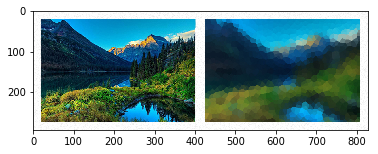

hamming distance:  4


In [211]:
imgplot = plt.imshow(Image.open('/Users/lisha/Desktop/show_images/1.jpg'))
plt.show()
print('hamming distance: ',hamming(h0,h1))

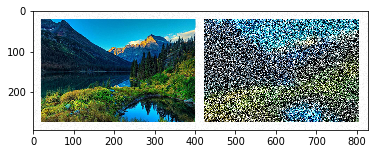

hamming distance:  1


In [212]:
imgplot = plt.imshow(Image.open('/Users/lisha/Desktop/show_images/2.jpg'))
plt.show()
print('hamming distance: ',hamming(h0,h2))

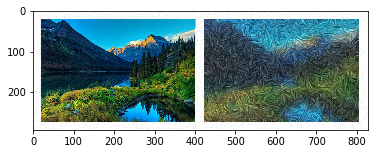

hamming distance:  0


In [213]:
imgplot = plt.imshow(Image.open('/Users/lisha/Desktop/show_images/3.jpg'))
plt.show()
print('hamming distance: ',hamming(h0,h3))

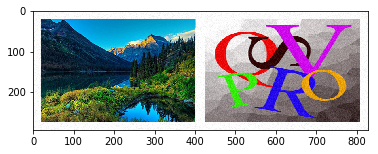

hamming distance:  14


In [215]:
imgplot = plt.imshow(Image.open('/Users/lisha/Desktop/show_images/4.jpg'))
plt.show()
print('hamming distance: ',hamming(h0,h4))

In [257]:
# functions used to get hashing value and hamming distance
def get_hash(image):
    return str(imagehash.average_hash(Image.open(image)))

def get_hashlist(images):
    list_hash=[]
    for image in images:
        list_hash.append(get_hash(image))
    return list_hash

def hamming(str1, str2):
    diffs = 0
    for ch1, ch2 in zip(str1, str2):
        if ch1 != ch2:
            diffs += 1
    return diffs

def hamming_list(hash_list1, hash_list2):
    dif_list=[]
    i=0
    j=0
    for i in range(len(hash_list1)):
        for j in range(len(hash_list2)):
            dif_list.append(hamming(hash_list1[i],hash_list2[j]))
    return dif_list

### 2. Take samples from dataset and see hamming distance between same/different classes

In [313]:
h0=get_hash('/Users/lisha/Desktop/show_images/original.jpg')
h1=get_hash('/Users/lisha/Desktop/show_images/low1.jpg')
h2=get_hash('/Users/lisha/Desktop/show_images/low2.jpg')
h3=get_hash('/Users/lisha/Desktop/show_images/low3.jpg')
h4=get_hash('/Users/lisha/Desktop/show_images/low4.jpg')
print('Hshing for original image: ',h0)
print('Hshing for distorted img1: ',h1)
print('Hshing for distorted img2: ',h2)
print('Hshing for distorted img3: ',h3)
print('Hshing for distorted img4: ',h4)

Hshing for original image:  fefc1800c05c0737
Hshing for distorted img1:  fefc1880c05e077f
Hshing for distorted img2:  fefc1800c05c0733
Hshing for distorted img3:  fefc1800c05c0737
Hshing for distorted img4:  ffefc74707070300


In [314]:
ha2=hamming(h0,h2)
ha3=hamming(h0,h3)
ha4=hamming(h0,h4)

In [252]:
list_cat=get_hashlist(list_file_cat)
list_dog=get_hashlist(list_file_dog)
list_truck=get_hashlist(list_file_truck)

In [253]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import warnings

In [254]:
plotly.tools.set_credentials_file(username='asahoho', api_key='9ibe6uhTBjIiY4eNOym2')

In [312]:
def get_hash(image):
    return str(imagehash.average_hash(Image.open(image)))
N=100
trace0 = go.Scatter(
    x = np.random.randn(N),
    y = hamming_list(list_cat[:100], list_cat[:100]),
    name = 'cat-cat',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)',
        line = dict(
            width = 1,
            color = 'rgb(0, 0, 0)'
        )
    )
)

trace1 = go.Scatter(
    x = np.random.randn(N),
    y = hamming_list(list_dog[:100], list_dog[:100]),
    name = 'dog-dog',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgba(255, 182, 193, .9)',
        line = dict(
            width = 1
        )
    )
)

trace2 = go.Scatter(
    x = np.random.randn(N),
    y = hamming_list(list_dog[:100], list_truck[:100]),
    name = 'truck-dog',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'white',
        line = dict(
            width = 1,
            color = 'rgb(0, 0, 0)'
        )
    )
)

data = [trace0, trace1, trace2]
layout = dict(
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')



High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~asahoho/0 or inside your plot.ly account where it is named 'styled-scatter'


In [307]:
print('Hamming Distance under 10 -- average hashing')
print('cat-cat: ', len(y1))
print('dog-dog: ', len(y2))
print('truck-dog: ', len(y3))

Hamming Distance under 10 -- average hashing
cat-cat:  270
dog-dog:  346
truck-dog:  139


In [300]:
y_aver_1=hamming_list(list_cat[:100], list_cat[:100])
y_aver_2= hamming_list(list_dog[:100], list_dog[:100])
y_aver_3=hamming_list(list_dog[:100], list_truck[:100])

In [301]:
y1=[num for num in y_aver_1 if num<10]
y2=[num for num in y_aver_2 if num<10]
y3=[num for num in y_aver_3 if num<10]

In [299]:
def get_hash(image):
    return str(imagehash.dhash(Image.open(image)))

In [256]:
N=100
trace0 = go.Scatter(
    x = np.random.randn(N),
    y1 = hamming_list(list_cat[:100], list_cat[:100]),
    name = 'cat-cat',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)',
        line = dict(
            width = 1,
            color = 'rgb(0, 0, 0)'
        )
    )
)

trace1 = go.Scatter(
    x = np.random.randn(N),
    y2 = hamming_list(list_dog[:100], list_dog[:100]),
    name = 'dog-dog',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgba(255, 182, 193, .9)',
        line = dict(
            width = 1
        )
    )
)

trace2 = go.Scatter(
    x = np.random.randn(N),
    y3 = hamming_list(list_dog[:100], list_truck[:100]),
    name = 'truck-dog',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'white',
        line = dict(
            width = 1,
            color = 'rgb(0, 0, 0)'
        )
    )
)

data = [trace0, trace1, trace2]
layout = dict(
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~asahoho/0 or inside your plot.ly account where it is named 'styled-scatter'


In [308]:
print('Hamming Distance under 10 -- d-hashing')
print('cat-cat: ', len(y1))
print('dog-dog: ', len(y2))
print('truck-dog: ', len(y3))

Hamming Distance under 10 -- d-hashing
cat-cat:  270
dog-dog:  346
truck-dog:  139


In [295]:
y_d_1=hamming_list(list_cat[:100], list_cat[:100])
y_d_2= hamming_list(list_dog[:100], list_dog[:100])
y_d_3=hamming_list(list_dog[:100], list_truck[:100])

In [296]:
y1=[num for num in y_d_1 if num<10]
y2=[num for num in y_d_2 if num<10]
y3=[num for num in y_d_3 if num<10]

In [298]:
len(y2)

346

In [294]:
def get_hash(image):
    return str(imagehash.phash(Image.open(image)))

In [260]:
N=100
trace0 = go.Scatter(
    x = np.random.randn(N),
    y = hamming_list(list_cat[:100], list_cat[:100]),
    name = 'cat-cat',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)',
        line = dict(
            width = 1,
            color = 'rgb(0, 0, 0)'
        )
    )
)

trace1 = go.Scatter(
    x = np.random.randn(N),
    y = hamming_list(list_dog[:100], list_dog[:100]),
    name = 'dog-dog',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgba(255, 182, 193, .9)',
        line = dict(
            width = 1
        )
    )
)

trace2 = go.Scatter(
    x = np.random.randn(N),
    y = hamming_list(list_dog[:100], list_truck[:100]),
    name = 'truck-dog',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'white',
        line = dict(
            width = 1,
            color = 'rgb(0, 0, 0)'
        )
    )
)

data = [trace0, trace1, trace2]
layout = dict(
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~asahoho/0 or inside your plot.ly account where it is named 'styled-scatter'


In [481]:
print('Hamming Distance under 10 -- d-hashing')
print('cat-cat:   ', len(y1))
print('dog-dog:   ', len(y2))
print('truck-dog: ', len(y3))

Hamming Distance under 10 -- d-hashing
cat-cat:    270
dog-dog:    346
truck-dog:  139


## Part 3 Build a CNN model using tensorflow

In [321]:
def main_network(images, training):
    x_pretty = pt.wrap(images)
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer        
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true).\
    return y_pred, loss

In [322]:
def create_network(training):
    with tf.variable_scope('network', reuse=tf.AUTO_REUSE):
        images = x
        images = pre_process(images=images)
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

In [323]:
def predict_cls(images, labels, cls_true):
    num_images = len(images)
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    i = 0
    while i < num_images:
        j = min(i + batch_size, num_images)
        feed_dict = {x: images[i:j, :],y_true: labels[i:j, :]}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    correct = (cls_true == cls_pred)    
    return correct, cls_pred
def get_test_acc(batch_size, images_test):
    correct, cls_pred = predict_cls(images = images_test, labels = lab_test, cls_true = cl_test)
    acc, num_correct = correct.mean(), correct.sum()
    num_images = len(correct)
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    return acc

In [443]:
def get_acc(train_batch_size, images_train, labels_train):
    start_time = time.time()
    RUN=True
    l_accuracy=[]
    l_step=[]
    l_time=[]
    batch_acc=0
    for i in range(num_iterations):
        w1=get_weights_variable(layer_name='layer_conv1')
        w2=get_weights_variable(layer_name='layer_conv2')
        tf.summary.scalar('accuracy', accuracy)
        tf.summary.histogram('weights1',w1)
        tf.summary.histogram('weights2',w2)
        x_batch, y_true_batch = helper.random_batch(train_batch_size, images_train, labels_train)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)#global step
        
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
            s=session.run(summary, feed_dict=feed_dict_train)
            summary_writer.add_summary(s,i)
               
        l_accuracy.append(batch_acc)
        l_step.append(i_global)
        l_time.append(time.time())
        
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    return l_accuracy, l_step, time_dif, l_time

### 1. Train the CNN model and optimize variables during traing.

In [515]:
path_board='/Users/lisha/Desktop/tensor_board/'

In [516]:
train_batch_size = 64
num_iterations=10000

In [517]:
tf.reset_default_graph()

In [518]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [519]:
global_step = tf.Variable(initial_value=0, name='global_step')
_, loss = create_network(training=True)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
session = tf.Session()


In [520]:
w = tf.Variable(tf.truncated_normal([5,5,3,64], stddev=0.1),name="w")
b = tf.Variable(tf.constant(0.1,shape=[64]), name="b")

In [521]:
init_op = tf.global_variables_initializer()
session.run(init_op)

In [522]:
summary = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(path_board+'original_1')
summary_writer.add_graph(session.graph)

In [523]:
l_acc_1, l_step_1, t_diff_1, l_time_1=get_acc(train_batch_size=train_batch_size, images_train=images_train, labels_train=labels_train)

Global Step:    100, Training Batch Accuracy:  67.2%
Global Step:    200, Training Batch Accuracy:  65.6%
Global Step:    300, Training Batch Accuracy:  57.8%
Global Step:    400, Training Batch Accuracy:  59.4%
Global Step:    500, Training Batch Accuracy:  62.5%
Global Step:    600, Training Batch Accuracy:  62.5%
Global Step:    700, Training Batch Accuracy:  53.1%
Global Step:    800, Training Batch Accuracy:  45.3%
Global Step:    900, Training Batch Accuracy:  64.1%
Global Step:   1000, Training Batch Accuracy:  53.1%
Global Step:   1100, Training Batch Accuracy:  64.1%
Global Step:   1200, Training Batch Accuracy:  68.8%
Global Step:   1300, Training Batch Accuracy:  53.1%
Global Step:   1400, Training Batch Accuracy:  71.9%
Global Step:   1500, Training Batch Accuracy:  48.4%
Global Step:   1600, Training Batch Accuracy:  65.6%
Global Step:   1700, Training Batch Accuracy:  57.8%
Global Step:   1800, Training Batch Accuracy:  68.8%
Global Step:   1900, Training Batch Accuracy: 

### 2. Get test accuracy

In [525]:
batch_size = 256 
t1=get_test_acc(batch_size=batch_size, images_test=img_test)

Accuracy on Test-Set: 54.6% (1092 / 2000)


### 3. Get accuracy of distorted images

In [532]:
batch_size = 256 
t_t=get_test_acc(batch_size=batch_size,images_test=images_test_distorted)

Accuracy on Test-Set: 49.6% (993 / 2000)


In [540]:
save_record('original_1',l_acc_1, l_step_1, t_diff_1, l_time_1,t1)

In [396]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

In [440]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

In [441]:
contents = session.run(weights_conv2)

In [442]:
np.ma.shape(contents)

(5, 5, 64, 64)

## Part 4 Use perceptual hashing algorithm to train the CNN model

### 1. Train with perceptual hashing preprocessed images

In [457]:
train_batch_size = 64
num_iterations=10000

In [458]:
tf.reset_default_graph()

In [459]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [460]:
global_step = tf.Variable(initial_value=0, name='global_step')
_, loss = create_network(training=True)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
session = tf.Session()
w = tf.Variable(tf.truncated_normal([5,5,3,64], stddev=0.1),name="w")
b = tf.Variable(tf.constant(0.1,shape=[64]), name="b")
init_op = tf.global_variables_initializer()
session.run(init_op)

In [461]:
summary = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(path_board+'hashing')
summary_writer.add_graph(session.graph)

In [462]:
l_acc_h, l_step_h, t_diff_h, l_time_h=get_acc(train_batch_size, images_train_h, labels_train)

Global Step:    100, Training Batch Accuracy:  64.1%
Global Step:    200, Training Batch Accuracy:  59.4%
Global Step:    300, Training Batch Accuracy:  64.1%
Global Step:    400, Training Batch Accuracy:  64.1%
Global Step:    500, Training Batch Accuracy:  71.9%
Global Step:    600, Training Batch Accuracy:  65.6%
Global Step:    700, Training Batch Accuracy:  57.8%
Global Step:    800, Training Batch Accuracy:  75.0%
Global Step:    900, Training Batch Accuracy:  62.5%
Global Step:   1000, Training Batch Accuracy:  71.9%
Global Step:   1100, Training Batch Accuracy:  68.8%
Global Step:   1200, Training Batch Accuracy:  79.7%
Global Step:   1300, Training Batch Accuracy:  67.2%
Global Step:   1400, Training Batch Accuracy:  75.0%
Global Step:   1500, Training Batch Accuracy:  71.9%
Global Step:   1600, Training Batch Accuracy:  81.2%
Global Step:   1700, Training Batch Accuracy:  65.6%
Global Step:   1800, Training Batch Accuracy:  78.1%
Global Step:   1900, Training Batch Accuracy: 

### 2. Test accuracy

In [471]:
batch_size = 256 
t=get_test_acc(batch_size=batch_size,images_test=images_test_h)

Accuracy on Test-Set: 68.2% (1364 / 2000)


In [465]:
save_record('hashing',l_acc_h, l_step_h, t_diff_h, l_time_h, t)

In [387]:
def save_record(name,acc,step,time_dif,time,t):
    list_col=['accuracy','step','time_dif','time','accuracy_test']
    df=pd.DataFrame(columns=list_col)
    df['accuracy']=acc
    df['step']=step
    df['time_dif']=time_dif
    df['time']=time
    df['accuracy_test']=t
    path='/Users/lisha/Desktop/model_record/'+name+'.csv'
    df.to_csv(path, sep=',',header=False,index=False)

## Print results of both models

In [537]:
df_result = pd.DataFrame({'Attributes': ['training accuracy','steps to reach 90% accuracy','average_accuracy_cross_entropy', 'loss cost', 'test accuracy'],
                    'Original': ["%s%%"%84.4 , 9000, 0.23, 0.32, "%s%%"%54.6],
                   'Perceptual Hashing':["%s%%"%100, 3600, 0.3, 0.03, "%s%%"%68.2]})

In [538]:
df_result=df_result.set_index(['Attributes','Original','Perceptual Hashing'])

In [539]:
df_result

,,
Attributes,Original,Perceptual Hashing
training accuracy,84.4%,100%
steps to reach 90% accuracy,9000,3600
average_accuracy_cross_entropy,0.23,0.3
loss cost,0.32,0.03
test accuracy,54.6%,68.2%


In [474]:
def get_layer_output(layer_name):
    tensor_name = "network/" + layer_name + "/Relu:0"
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [475]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')